In [1]:
import matplotlib.pyplot as plt
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml

import pickle
import pathlib

import mlflow

In [2]:
from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 25
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/doe4rl")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/experiments/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(path_mlruns)

# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    # list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    # assert len(list_glob_config) == 1, "More than one config file in the directory."

    # name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    # assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    # path_run_config_yaml = list_glob_config[0]

    dict_config_temp = mlflow.get_run(name_id).data.params
    nested_dict_config[name_id] = dict_config_temp
    list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
        
    # with open(path_run_config_yaml, "r") as file:
        # Get the config file as a dictionary
        # dict_config_temp = yaml.safe_load(file)
        # Add the config file to the nested dictionary
        # nested_dict_config[name_id] = dict_config_temp
        # Flatten the config file for easier check
        # list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    # del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name",
                               "_id"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

Number of runs: 40 

XP id: 25 
Set of non unique keys: {'seed', '_id', 'alg_n_semimarkov_dt'} 

First config file: e58d331d91674dbe8de11f4f78974268 

path_sampling_noise: '0.01'
name: 2023_12_08_pendulum_sm_action_0.5_ep_length_300_num_iters_100
num_eval_trials: '5'
eigmpc_nsamps: '25'
env_environment_parameters_dict_pde_config_ep_length: '300'
env_mpc_n_elites: '1'
alg_sample_all_states: 'False'
env_tf_precision: '64'
test_mpc_n_elites: '1'
alg_learn_reward: 'False'
alg_open_loop_mpc: 'False'
normalize_env: 'True'
test_mpc_actions_per_plan: '1'
mpc_planning_horizon: '2'
n_paths: '15'
test_mpc_beta: '1'
env_eigmpc_actions_per_plan: '1'
sample_init_initially: 'True'
env_eigmpc_gamma: '1.25'
env_eigmpc_planning_horizon: '2'
alg_uncertainty_sampling: 'False'
test_mpc_num_iters: '1'
alg_num_fs: '15'
path_sampling_fraction: '0.8'
test_mpc_num_fs: '15'
alg_kg_policy: 'False'
fit_hypers: 'False'
env_environment_parameters_dict_pde_config_dt: '0.05'
seed: '0'
env_gp_alpha: '[0.03, 13.94]'
tes

In [3]:
(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 # .groupby(["seed", "alg_n_semimarkov_dt"])
 # .loc[:, ["alg_num_iters", "crop_to_domain", "project_to_domain", "alg_n_semimarkov_dt", "seed", "name"]]
 .loc[:, ["alg_num_iters", "alg_n_semimarkov_dt", "seed", "name"]]
 .nunique()

 )

alg_num_iters           1
alg_n_semimarkov_dt     4
seed                   10
name                    1
dtype: int64

In [4]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }

# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"
    # list(path_experiment.iterdir())[0]

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)
    # nested_dict_config[name_id]["eval_frequency"] * (len(dict_data["x"]) - 1) + (len(dict_data["x"]) - 1) % nested_dict_config[name_id]["eval_frequency"]
    
    list_array = []
    eval_frequency = int(nested_dict_config[name_id]["eval_frequency"])
    
    list_excluded_columns_reshape = ["Acquisition Function Value", "mean_difference_state_boostrap", "n_corresponding_dt"]
    
    # Reshape array to have the same length as the number of iterations
    dict_temp = {name_column: list(dict_data[name_column][:1]) + list(np.repeat(dict_data[name_column][1:], eval_frequency, axis=0))[:-((len(dict_data["x"])) % eval_frequency)]
                 for name_column in list_name_columns_learning if name_column not in list_excluded_columns_reshape}
    # Add the excluded columns without reshaping
    dict_temp.update({name_column: dict_data[name_column] for name_column in list_excluded_columns_reshape})
    df_learning_data_temp = (
        pd.DataFrame(dict_temp)
        .explode("Eval Returns")
        .reset_index(names=["iteration"])
        .rename(columns=dict_columns_learning_renaming_map)
    )

    list_df_learning_data.append(df_learning_data_temp)

In [5]:
# Get the list of the delay mode
list_action_delay_mode = [int(nested_dict_config[name_id]["alg_n_semimarkov_dt"])
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [6]:
df_learning_data.describe()

,iteration,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
count,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000
mean,49.500000,50.990000,1.124050e-01,0.221400,0.095672,-1.853502,-1.873521,1.703150,1.062386e-01,2.979250
std,28.866792,28.862632,1.425862e-01,0.210420,0.121658,0.014503,0.040006,1.130952,6.037895e-01,2.311944
min,0.000000,1.000000,3.146318e-08,0.004106,0.000006,-1.927261,-2.085273,0.212358,0.000000e+00,1.000000
25%,24.750000,26.500000,2.566642e-02,0.025636,0.031377,-1.863844,-1.890207,0.857876,5.551115e-17,1.000000
50%,49.500000,51.000000,5.904227e-02,0.173465,0.059784,-1.850364,-1.857434,1.303286,4.001888e-04,2.000000
75%,74.250000,75.500000,1.506098e-01,0.370992,0.119968,-1.839989,-1.846062,2.233803,4.832082e-03,4.000000
max,99.000000,100.000000,1.096473e+00,1.111946,0.917294,-1.838171,-1.838055,6.463684,7.571392e+00,8.000000


In [7]:
n_eval_trajectory = int(nested_dict_config[list_id_hash[0]]["num_eval_trials"])

(df_learning_data
 .infer_objects()
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"]))

iteration  eval_returns  \
run_id                           action_delay_mode                            
e58d331d91674dbe8de11f4f78974268 4                          0  -1798.693456   
                                 4                          0  -2129.427168   
                                 4                          0  -1900.763540   
                                 4                          0  -2166.377513   
                                 4                          0  -1896.379359   
...                                                       ...           ...   
4c2e038972af45a680c6407643dbc302 2                         99   -422.887190   
                                 2                         99   -408.157850   
                                 2                         99   -704.280785   
                                 2                         99   -421.673628   
                                 2                         99   -731.716079   

                                                    eval_ndata  \
run_id                           action_delay_mode               
e58d331d91674dbe8de11f4f78974268 4                         1.0   
                                 4                         1.0   
                                 4                         1.0   
                                 4                         1.0   
                                 4                         1.0   
...                                                        ...   
4c2e038972af45a680c6407643dbc302 2                       100.0   
                                 2                       100.0   
                                 2                       100.0   
                                 2                       100.0   
                                 2                       100.0   

                                                    model_mse_current_real_mpc  \
run_id                           action_delay_mode                               
e58d331d91674dbe8de11f4f78974268 4                                    0.003805   
                                 4                                    0.003805   
                                 4                                    0.003805   
                                 4                                    0.003805   
                                 4                                    0.003805   
...                                                                        ...   
4c2e038972af45a680c6407643dbc302 2                                    0.181463   
                                 2                                    0.181463   
                                 2                                    0.181463   
                                 2                                    0.181463   
                                 2                                    0.181463   

                                                    model_mse_random_test_set  \
run_id                           action_delay_mode                              
e58d331d91674dbe8de11f4f78974268 4                                   0.004106   
                                 4                                   0.004106   
                                 4                                   0.004106   
                                 4                                   0.004106   
                                 4                                   0.004106   
...                                                                       ...   
4c2e038972af45a680c6407643dbc302 2                                   0.398301   
                                 2                                   0.398301   
                                 2                                   0.398301   
                                 2                                   0.398301   
                                 2                                   0.398301   

                                            

In [8]:
(df_learning_data
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"])
 .reset_index()
 .groupby(["trajectory_id", "action_delay_mode", "run_id"])
 .rolling(window=10, min_periods=1)
 .mean()
 .reset_index()
 )

,trajectory_id,action_delay_mode,run_id,level_3,iteration,eval_returns,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
0,0,1,2b9628b2db26417fbd9ecdab14ec6c92,11500,0.0,-2211.735909,1.000000,0.003378,0.004456,0.002140,-1.838709,-1.838252,4.037695,0.000000,1.0
1,0,1,2b9628b2db26417fbd9ecdab14ec6c92,11505,0.5,-2572.852066,2.000000,0.019801,0.006352,0.032742,-1.838871,-1.841824,4.656417,0.000000,1.0
2,0,1,2b9628b2db26417fbd9ecdab14ec6c92,11510,1.0,-2693.224119,2.333333,0.025276,0.006984,0.042943,-1.838925,-1.843015,4.883439,0.000000,1.0
3,0,1,2b9628b2db26417fbd9ecdab14ec6c92,11515,1.5,-2753.347649,3.000000,0.026842,0.007115,0.046549,-1.838937,-1.843514,4.315558,0.000000,1.0
4,0,1,2b9628b2db26417fbd9ecdab14ec6c92,11520,2.0,-2789.421768,3.400000,0.027781,0.007194,0.048713,-1.838945,-1.843813,3.926531,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4,8,db5ead6b035f49b7beb72c12a308b6a4,19479,90.5,-476.719029,92.000000,0.240941,0.272704,0.149660,-1.863602,-1.933920,0.673095,0.004869,4.4
19996,4,8,db5ead6b035f49b7beb72c12a308b6a4,19484,91.5,-476.793170,93.000000,0.238924,0.271072,0.148217,-1.863489,-1.933218,0.684983,0.005247,4.9
19997,4,8,db5ead6b035f49b7beb72c12a308b6a4,19489,92.5,-474.507039,94.000000,0.237336,0.269859,0.147027,-1.863417,-1.932726,0.677826,0.005247,4.9
19998,4,8,db5ead6b035f49b7beb72c12a308b6a4,19494,93.5,-472.220907,95.000000,0.235749,0.268646,0.145838,-1.863346,-1.932234,0.671683,0.003754,4.3


##### Plotting metrics from pickle data

================== eig ==================


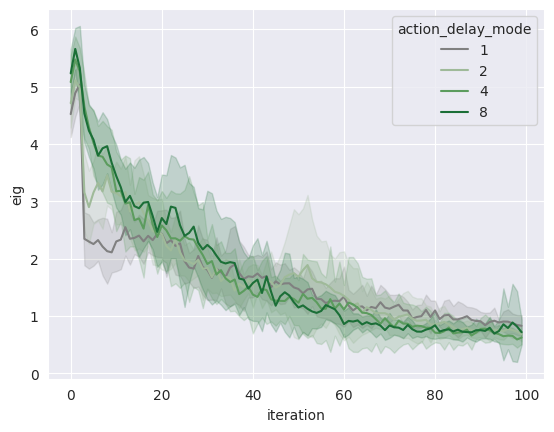

================== eval_returns ==================


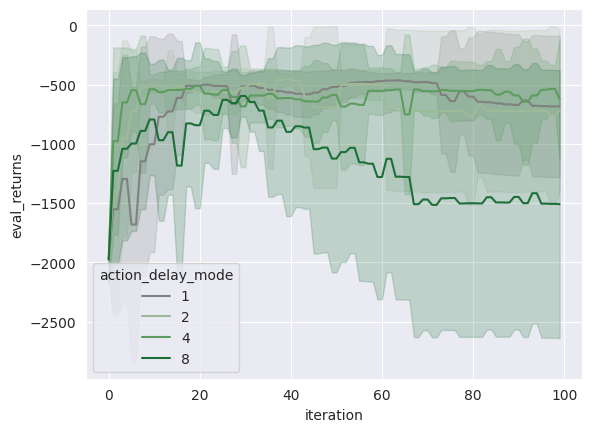

================== mean_difference_state_bootstrap ==================


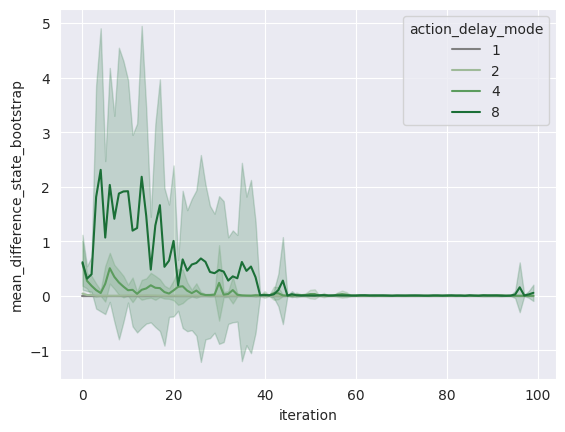

================== n_corresponding_dt ==================


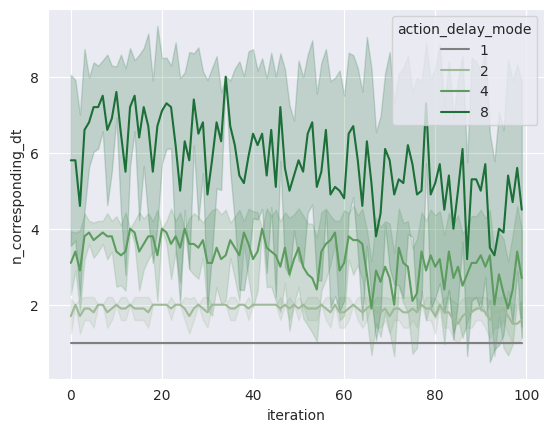

================== model_mse_current_real_mpc ==================


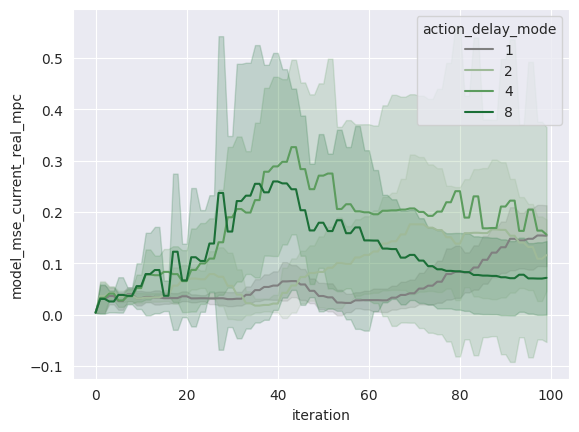

================== model_mse_random_test_set ==================


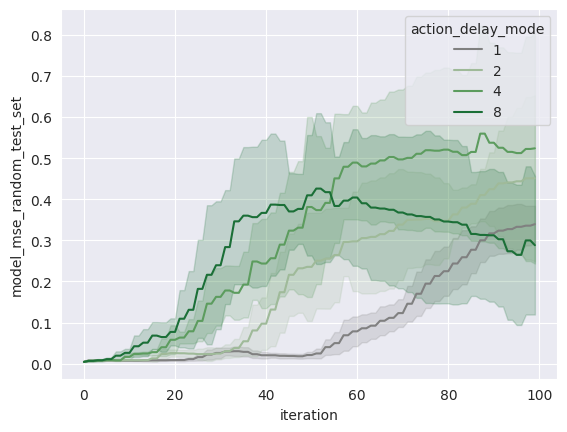

================== model_mse_gt_mpc ==================


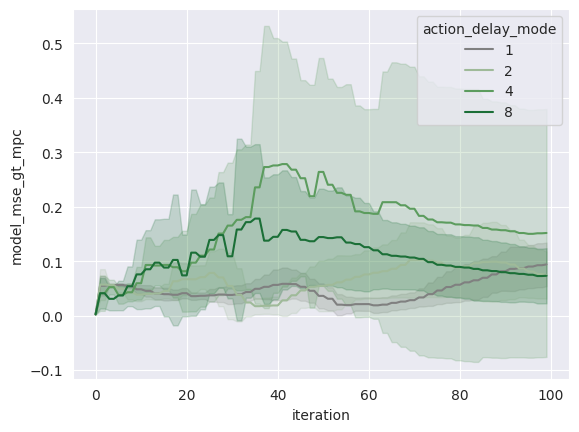

================== model_likelihood_random_test_set ==================


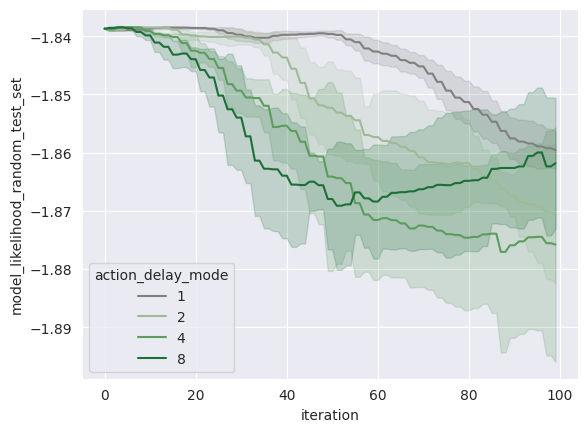

================== model_likelihood_gt_mpc ==================


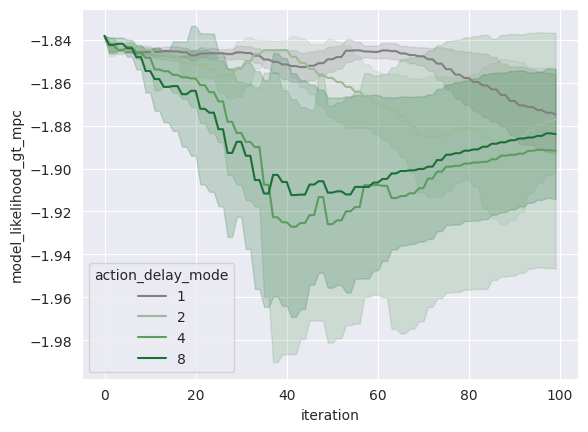

================== eval_ndata ==================


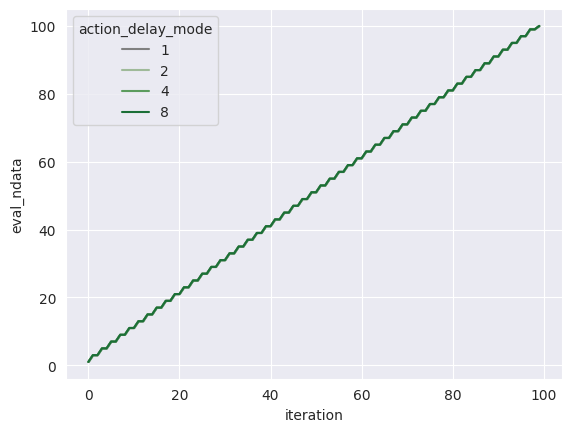

In [9]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Greens", len(set(list_action_delay_mode)) - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.8
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["Grey"] + sns_other_palette
# list_color_palette = ["black"] + sns.color_palette("Greens", len(list_action_delay_mode) - 1).as_hex()
df_plot = df_learning_data.reset_index()

list_columns_plot = ["eig", "eval_returns", "mean_difference_state_bootstrap", "n_corresponding_dt",
                     "model_mse_current_real_mpc", "model_mse_random_test_set",
                     "model_mse_gt_mpc", "model_likelihood_random_test_set", "model_likelihood_gt_mpc", "eval_ndata"]

plt.close()
for name_column in list_columns_plot:
    print(f"================== {name_column} ==================")
    g = sns.lineplot(data=df_plot,
                     x="iteration",
                     y=name_column,
                     hue="action_delay_mode",
                     errorbar="sd",
                     legend="full",
                     palette=list_color_palette)
    plt.show()
    # Save the   figure
    # g.figure.savefig(f"/home/hosseinkhan/Downloads/temp_imgs/{name_column}.png")
    # plt.close()

##### Moving average of the eval returns

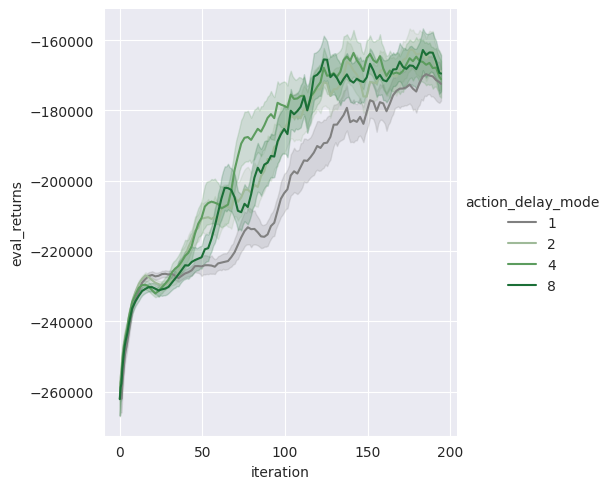

In [35]:
df_plot = (df_learning_data
           .reset_index(level=-1)
           .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
           .drop(columns=["level_2"])
           .reset_index()
           .groupby(["trajectory_id", "action_delay_mode", "run_id"])
           .rolling(window=10   , min_periods=1)
           .mean()
           .reset_index()
           )

# Seaborn lineplot of eval returns
sns.relplot(data=df_plot,
            x="iteration",
            y="eval_returns",
            hue="action_delay_mode",
            # col="trajectory_id",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3, 
            )

In [36]:
dim_x = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["alpha"])
dim_u = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["ls"][0]) - dim_x

list_df_trajectory_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

    df_trajectory_data_temp = (pd.concat(
        [pd.DataFrame(np.array(dict_data["x"])[:, :dim_x]), pd.DataFrame(np.array(dict_data["x"])[:, dim_x:])],
        axis="columns",
        keys=["state", "action"],
        names=["component", "i"]).assign(n_corresponding_dt=[0] + list(np.array(dict_data["n_corresponding_dt"])),
                                         iteration=[0] + list(np.array(dict_data["n_corresponding_dt"]).cumsum())
                                         )
                               )

    list_df_trajectory_data.append(df_trajectory_data_temp)

KeyError: 'env'

In [ ]:
df_trajectory_data = pd.concat(list_df_trajectory_data, keys=list_keys_tuple_id_action_delay_mode,
                               names=["run_id", "action_delay_mode"])

In [ ]:
df_trajectory_data

In [ ]:
df_trajectory_data.describe()

In [ ]:
df_trajectory_data["state", 0] *= 80
df_trajectory_data["state", 1] *= 8

df_trajectory_data["action", 0] *= 2


In [ ]:
df_trajectory_data.describe()

In [ ]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

In [ ]:
df_temp = (df_trajectory_data
           .set_index(["n_corresponding_dt", "iteration"], append=True)
           .stack(level=["component", "i"])
           .rename("system_value")
           .reset_index()
           .drop(columns="level_2"))

sns.relplot(data=df_temp,
            x="iteration",
            y="system_value",
            hue="action_delay_mode",
            col="i",
            row="component",
            # kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            s=3, )

##### Action distribution along time

In [ ]:
window_size = 10
df_temp = (df_trajectory_data
           .loc[pd.IndexSlice[:, :, :], ["action"]]
           .groupby(["run_id", "action_delay_mode"], as_index=False)
           .rolling(window=window_size, min_periods=1)
           .mean()
           .drop(columns=["run_id", "action_delay_mode"])
           .stack(level=-1)
           .reset_index()
           .rename(columns={"level_2": "iteration"}))

# Plot the time series
sns.relplot(data=df_temp,
            x="iteration",
            y="action",
            hue="action_delay_mode",
            col="i",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3,
            )

In [ ]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

In [ ]:
df_temp = (df_trajectory_data
.set_index(["n_corresponding_dt", "iteration"], append=True)
.stack(level=["component", "i"])
.rename("system_value")
.reset_index()
.drop(columns="level_2")
# Extract only the state
.loc[lambda df: df["component"] == "state"]
)

# Plot the statistics with boxplot
sns.catplot(data=df_temp,
            col="i",
            y="system_value",
            hue="action_delay_mode",
            # col="i",
            # col="component",
            # row="statistic",
            # kind="line",
            # no sharing of y axis rowwise
            sharey=False,
            # facet_kws=dict(sharey=False),
            # common_bins=False,
            kind="box",
            # bins=50
            # reduce size of markers
            # s=3,
            )